In [1]:
!pip install torchkge
!pip install rdflib
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 1.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [2]:
from torchkge.data_structures import KnowledgeGraph
from rdflib import URIRef, Literal, Graph
import pandas as pd

# Load the already stored graph. If we are predicting/fine-tuning, we only need the

g = Graph()
g.parse("graph_final.ttl", format="ttl")

triples = []
for s, p, o in g:
    triples.append((str(s), str(p), str(o)))

data = pd.DataFrame(triples)
data.columns = ['from','rel','to']
data = data[['from','to','rel']]

/usr/local/lib/python3.10/dist-packages/torchkge/utils/data_redundancy.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
data.shape

(16883, 3)

In [4]:
# Split data into train, validation and test sets
train = data.sample(frac=0.8, random_state=0)
data = data.drop(train.index)
val = data.sample(frac=0.5, random_state=0)
test = data.drop(val.index)

# Create a KnowledgeGraph object
kg_train = KnowledgeGraph(df=train)
kg_val = KnowledgeGraph(df=val)
kg_test = KnowledgeGraph(df=test)

In [19]:
from torch.optim import Adam

from torchkge.evaluation import LinkPredictionEvaluator
from torchkge.models import TransEModel
from torchkge.utils.datasets import load_fb15k
from torchkge.utils import Trainer, MarginLoss, DataLoader
from torchkge.sampling import BernoulliNegativeSampler
from torchkge.utils.pretrained_models import load_pretrained_transe

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

In [14]:
emb_dim = 100
model = TransEModel(emb_dim, kg_train.n_ent, kg_train.n_rel, dissimilarity_type='L2')

In [15]:
lr = 0.0004
margin = 0.5
n_epochs = 1000
b_size = 32768

In [16]:
criterion = MarginLoss(margin)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [17]:
sampler = BernoulliNegativeSampler(kg_train)
dataloader = DataLoader(kg_train, batch_size=b_size, use_cuda=None)

train_losses = []
val_losses = []

iterator = tqdm(range(n_epochs), unit='epoch')
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        pos, neg = model(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(dataloader))

    # Calculate validation loss
    val_loss = 0.0
    val_dataloader = DataLoader(kg_val, batch_size=b_size, use_cuda=None)
    for i, batch in enumerate(val_dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        pos, neg = model(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        val_loss += loss.item()

    val_losses.append(val_loss / len(val_dataloader))

    iterator.set_description(
        'Epoch {} | mean loss: {:.5f} | val loss: {:.5f}'.format(
            epoch + 1, running_loss / len(dataloader), val_loss / len(val_dataloader)
        )
    )

model.normalize_parameters()

  0%|          | 0/1000 [00:00<?, ?epoch/s]

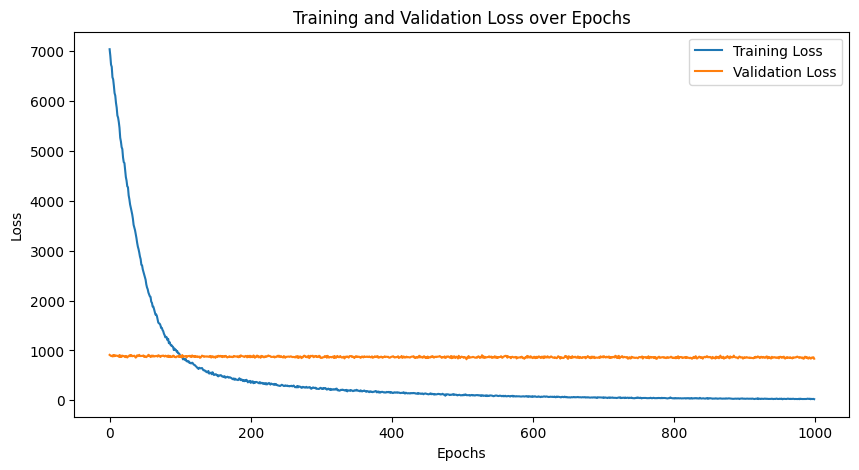

In [20]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

In [21]:
# Save the model
import torch
torch.save(model.state_dict(), 'TransE_model.pth')

In [11]:
# Link prediction evaluation on test set.
evaluator = LinkPredictionEvaluator(model, kg_test)
evaluator.evaluate(b_size=32)
evaluator.print_results()

Link prediction evaluation:   0%|          | 0/53 [00:00<?, ?batch/s]

Hit@10 : 0.001 		 Filt. Hit@10 : 0.001
Mean Rank : 5971 	 Filt. Mean Rank : 5968
MRR : 0.001 		 Filt. MRR : 0.001


In [12]:
# Triplet classification evaluation on test set by learning thresholds on validation set
from torchkge.evaluation import TripletClassificationEvaluator
evaluator = TripletClassificationEvaluator(model, kg_val, kg_test)
evaluator.evaluate(b_size=128)

print('Accuracy on test set: {}'.format(evaluator.accuracy(b_size=128)))

Accuracy on test set: 0.4988158673771462
